# `pauc`: A Python Library for ROC Curve Analysis
This notebook provides a comprehensive guide to using the pauc library for Receiver Operating Characteristic (ROC) curve analysis. We will cover everything from creating and plotting basic ROC curves to advanced topics like statistical comparison, confidence intervals, multi-class analysis, and power calculations.

## 1\. Installation

First, you'll need to install the `pauc` library. You can typically do this using `pip`:

```python
!pip install pauc
```

In [37]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pauc

### Understanding the `ROC` Object

The `ROC` object has several useful attributes:

  * `roc.auc`: The Area Under the ROC Curve.
  * `roc.fpr`: An array of False Positive Rates.
  * `roc.tpr`: An array of True Positive Rates.
  * `roc.thresholds`: The thresholds used to calculate the FPR and TPR.
  * `roc.n_cases`: The number of positive samples.
  * `roc.n_controls`: The number of negative samples.

You can access these attributes directly:

## 3\. Plotting ROC Curves

Visualizing ROC curves is essential for understanding model performance. The `pauc` library provides a simple function, `plot_roc`, to do this.

In [2]:
with open('./baseline_ecfp4_binary.pickle', 'rb') as f:
    baseline_ecfp4_results = pickle.load(f)

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_88983/424124681.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  baseline_ecfp4_results = pickle.load(f)


In [3]:
with open('./maplight_binary.pickle', 'rb') as f:
    maplight_results = pickle.load(f)

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_88983/3905535138.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  maplight_results = pickle.load(f)


In [20]:
def plot_roc_refactored(roc_objects, title="ROC Curves", plot_ci=True, annotate_best=True, ax=None):
    """
    Plots one or more ROC objects on a single axis.
    If an axis is provided, it plots on that axis. Otherwise, it creates a new figure.
    """
    if not isinstance(roc_objects, list):
        roc_objects = [roc_objects]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    for roc in roc_objects:
        label = roc.name if roc.name else "ROC Curve"
        auc_label = f"{label} (AUC = {roc.auc:.3f})"
        (line,) = ax.plot(roc.fpr, roc.tpr, label=auc_label)

        color = line.get_color()

        if plot_ci and roc.y_true is not None:
            points = np.linspace(1, 0, 100)
            lower, upper = pauc.ci_sensitivity(roc, points)
            fpr_points = 1 - points
            sort_idx = np.argsort(fpr_points)
            ax.fill_between(                                 
                fpr_points[sort_idx],
                lower[sort_idx],
                upper[sort_idx],
                color=color,
                alpha=0.2,
            )

        if annotate_best and roc.thresholds is not None:
            coords = roc.get_coords("best")
            ax.plot(                                          
                1 - coords["specificity"],
                coords["sensitivity"],
                "o",
                color=color,
                markersize=8,
            )
            ax.annotate(                                      
                f"Thresh={coords['threshold']:.2f}",
                (1 - coords["specificity"], coords["sensitivity"]),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )

    ax.plot([0, 1], [0, 1], color="grey", linestyle=":", label="No Skill (AUC = 0.500)")
    ax.set_aspect('equal', adjustable='box')  
    ax.set_xlim([0, 1])                       
    ax.set_ylim([0, 1])                       
    ax.set_xlabel("1 - Specificity (False Positive Rate)")
    ax.set_ylabel("Sensitivity (True Positive Rate)")     
    ax.set_title(title)                      
    ax.grid(True, linestyle="--", alpha=0.6) 
    ax.legend(loc="lower right")             

    return ax                                

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [02:32<00:00, 11.72s/it]


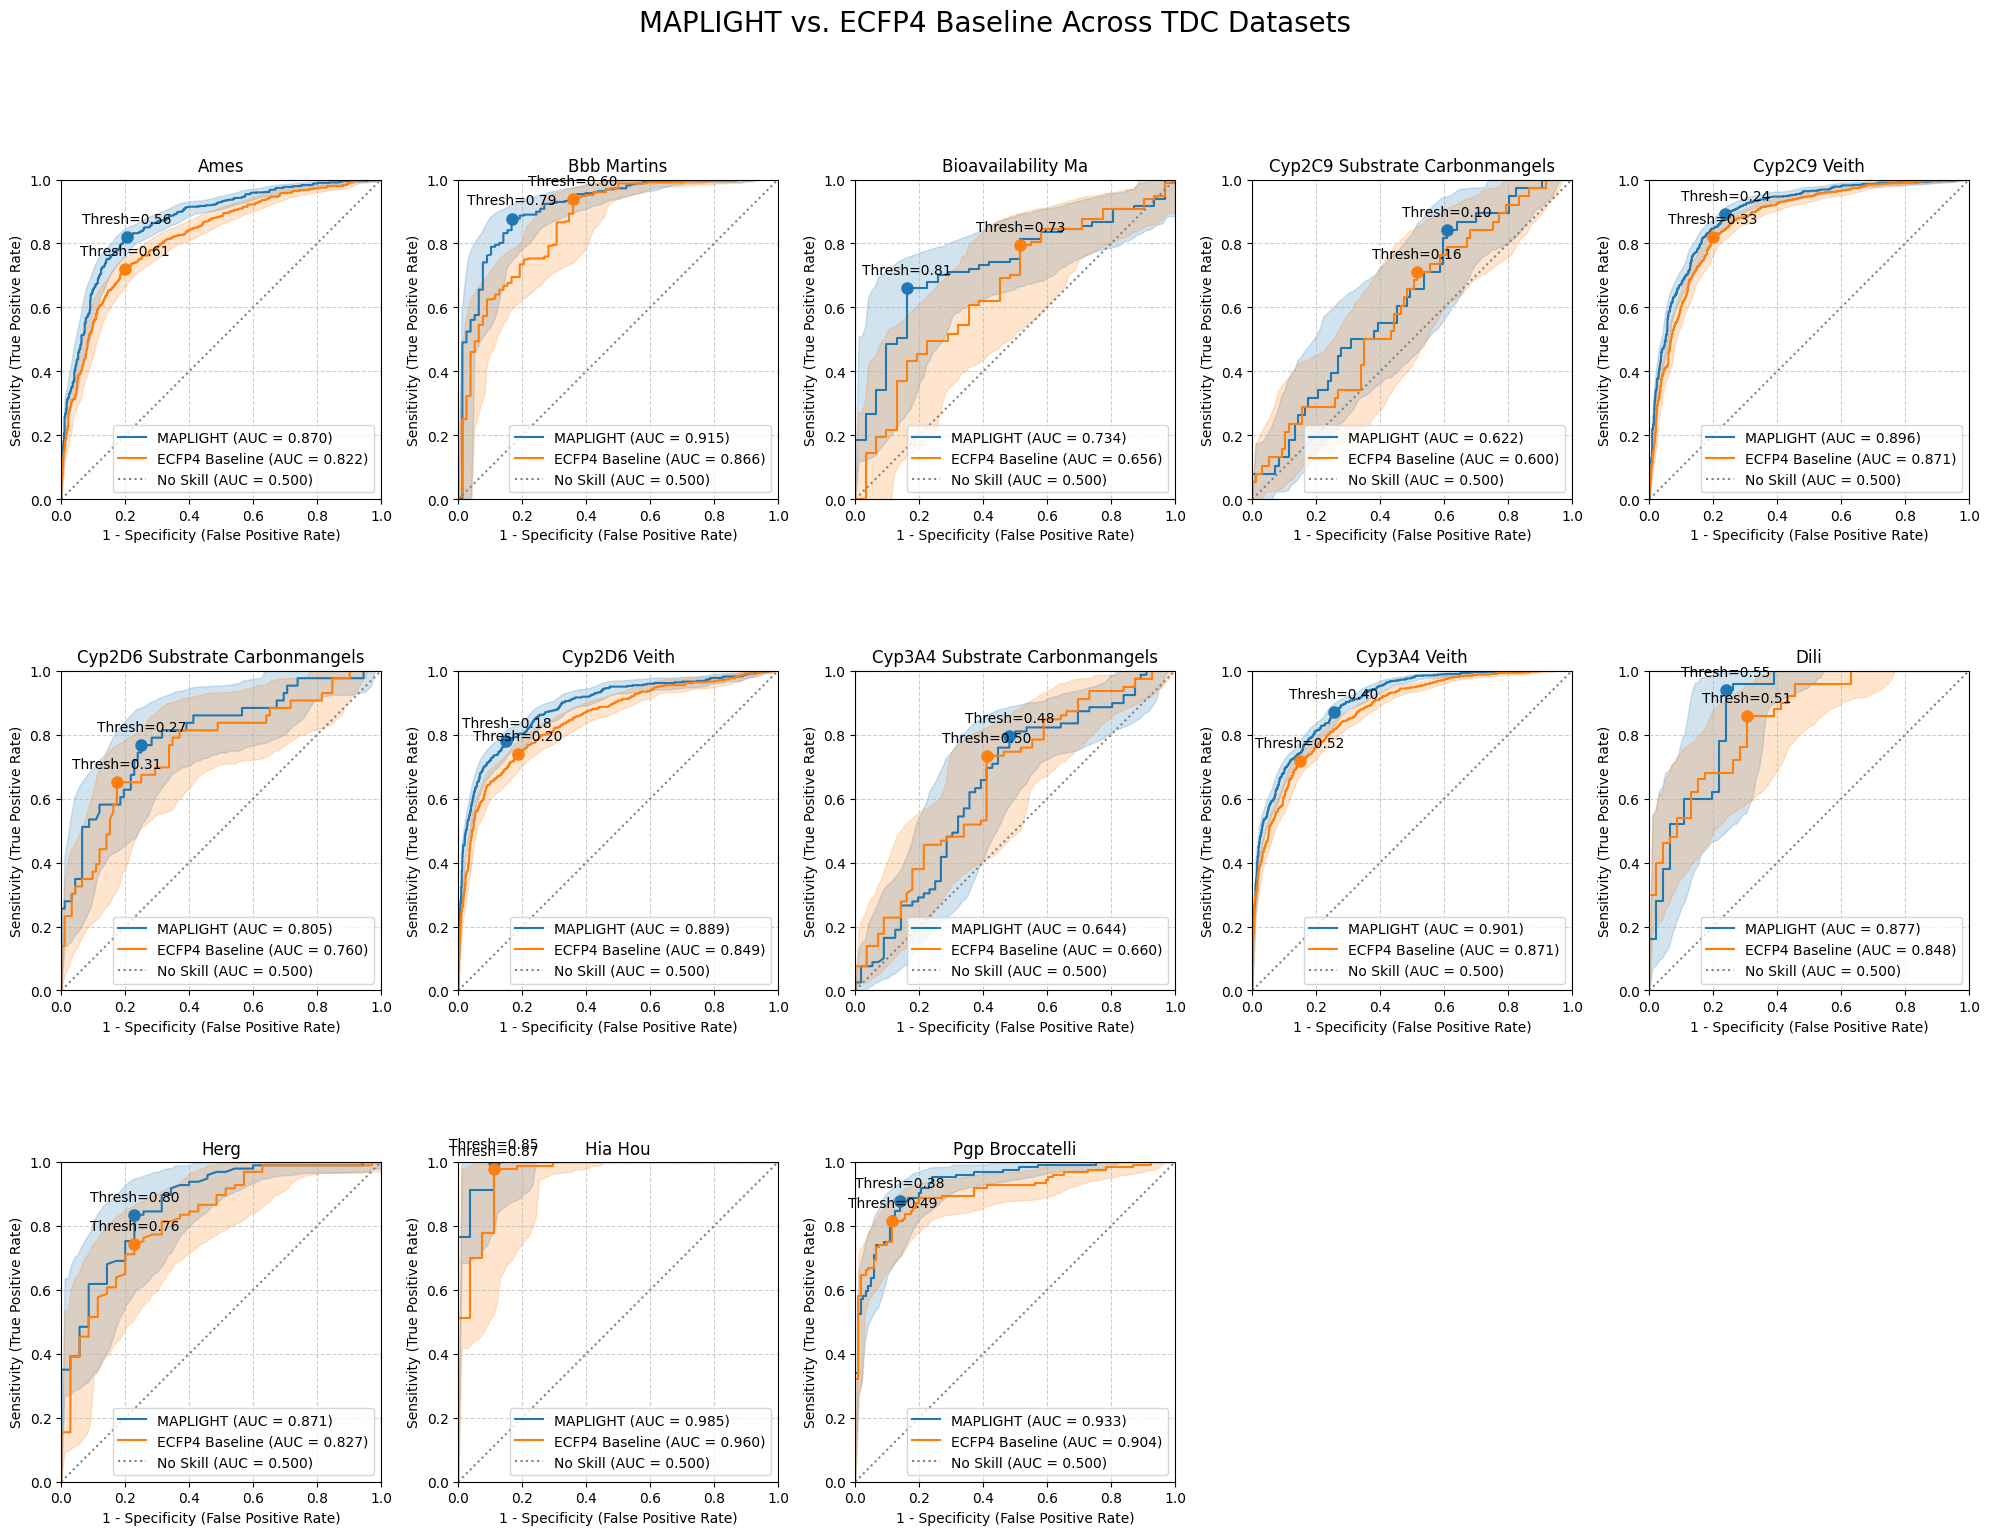

In [21]:
unique_dataset_keys = set([key.replace('_y_true', '').replace('_y_pred_proba', '')
                           for key in maplight_results.keys()])
sorted_dataset_names = sorted(list(unique_dataset_keys))

fig, axes = plt.subplots(3, 5, figsize=(20, 16))
axes = axes.flatten()

for i, dataset_name in tqdm(enumerate(sorted_dataset_names), total=len(sorted_dataset_names)):
    ax = axes[i] # Get the subplot

    y_true = maplight_results[f"{dataset_name}_y_true"]
    maplight_probs = maplight_results[f"{dataset_name}_y_pred_proba"]
    baseline_probs = baseline_ecfp4_results[f"{dataset_name}_y_pred_proba"]

    roc_maplight = pauc.ROC(y_true, maplight_probs, name='MAPLIGHT')
    roc_baseline = pauc.ROC(y_true, baseline_probs, name='ECFP4 Baseline')
    
    plot_roc_refactored(
        [roc_maplight, roc_baseline],
        title=f"{dataset_name.replace('_', ' ').title()}",
        ax=ax
    )

for j in range(len(sorted_dataset_names), len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('MAPLIGHT vs. ECFP4 Baseline Across TDC Datasets', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4\. Comparing ROC Curves

A common task in ROC analysis is to determine if the difference in AUC between two models is statistically significant. The `compare` function allows you to do this.

In [47]:
comparison_data = []
for dataset_name in tqdm(unique_dataset_keys):
    y_true = maplight_results[f"{dataset_name}_y_true"]
    maplight_probs = maplight_results[f"{dataset_name}_y_pred_proba"]
    baseline_probs = baseline_ecfp4_results[f"{dataset_name}_y_pred_proba"]

    roc_maplight = pauc.ROC(y_true, maplight_probs, name='MAPLIGHT')
    roc_baseline = pauc.ROC(y_true, baseline_probs, name='ECFP4 Baseline')

    res = pauc.compare(roc_maplight, roc_baseline, method='delong')
    # res = pauc.compare(roc_maplight, roc_baseline, method='bootstrap')
    # res = pauc.compare(roc_maplight, roc_baseline, method='venkatraman')
    p_value = res.p_value

    comparison_data.append({
        'Dataset': dataset_name.replace('_', ' '),
        'MAPLIGHT AUC': roc_maplight.auc,
        'ECFP4 AUC': roc_baseline.auc,
        'AUC Difference': roc_maplight.auc - roc_baseline.auc,
        'p-value': p_value
    })

results_df = pd.DataFrame(comparison_data)
results_df

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 43.56it/s]


,Dataset,MAPLIGHT AUC,ECFP4 AUC,AUC Difference,p-value
0,dili,0.877391,0.848261,0.029130,3.394235e-01
1,herg,0.871134,0.827246,0.043888,1.708267e-01
2,hia hou,0.984774,0.959671,0.025103,2.609853e-01
3,ames,0.869745,0.821699,0.048046,3.891953e-11
4,cyp2c9 substrate carbonmangels,0.622355,0.599566,0.022789,5.835913e-01
5,cyp3a4 substrate carbonmangels,0.643648,0.659923,-0.016275,6.232472e-01
6,bbb martins,0.914830,0.866440,0.048390,5.570211e-04
7,cyp3a4 veith,0.900767,0.871002,0.029764,4.694511e-11
8,cyp2d6 substrate carbonmangels,0.804727,0.760238,0.044489,1.593834e-01
9,pgp broccatelli,0.933085,0.904492,0.028592,6.404660e-02


The `compare` function supports several comparison methods:

  * **`delong`**: DeLong's test for correlated or uncorrelated ROC curves. This is a common and powerful non-parametric test.
  * **`bootstrap`**: A bootstrap test for comparing AUCs. This is computationally more intensive but can be more flexible.
  * **`venkatraman`**: Venkatraman's test, which compares the entire shape of the ROC curves, not just the AUC.

The `compare` function also has a `paired` parameter. If your models were tested on the same dataset, you should set `paired=True` (which is the default if the true labels are the same).

## 5\. Confidence Intervals

The `pauc` library provides functions to calculate confidence intervals for various ROC metrics.

### AUC Confidence Interval

You can calculate the confidence interval for the AUC using `ci_auc`:

In [53]:
ci_data = []

for dataset_name in unique_dataset_keys:
    y_true = maplight_results[f"{dataset_name}_y_true"]
    maplight_probs = maplight_results[f"{dataset_name}_y_pred_proba"]
    baseline_probs = baseline_ecfp4_results[f"{dataset_name}_y_pred_proba"]
    roc_maplight = pauc.ROC(y_true, maplight_probs, name='MAPLIGHT')
    roc_baseline = pauc.ROC(y_true, baseline_probs, name='ECFP4 Baseline')
    ci_maplight = pauc.ci_auc(roc_maplight, method='delong', conf_level=0.95)
    ci_baseline = pauc.ci_auc(roc_baseline, method='delong', conf_level=0.95)
    dataset_title = dataset_name.replace('_', ' ')
    ci_data.append({
        'Dataset': dataset_title, 'Model': 'MAPLIGHT',
        'CI_Lower': ci_maplight[0], 'CI_Upper': ci_maplight[1]
    })
    ci_data.append({
        'Dataset': dataset_title, 'Model': 'ECFP4 Baseline',
        'CI_Lower': ci_baseline[0], 'CI_Upper': ci_baseline[1]
    })

ci_df = pd.DataFrame(ci_data)
ci_df['AUC Range'] = ci_df.apply(
    lambda row: f"({row['CI_Lower']:.3f} - {row['CI_Upper']:.3f})",
    axis=1
)

# Pivot the table to get models as columns
comparison_table = ci_df.pivot(index='Dataset', columns='Model', values='AUC Range')

# Rename the columns to the desired format
comparison_table = comparison_table.rename(columns={
    'ECFP4 Baseline': 'Baseline AUC Range',
    'MAPLIGHT': 'Maplight AUC Range'
})

# Ensure the column order is consistent (Baseline first)
comparison_table = comparison_table[['Baseline AUC Range', 'Maplight AUC Range']]
comparison_table

Model,Baseline AUC Range,Maplight AUC Range
Dataset,,
ames,(0.800 - 0.843),(0.851 - 0.888)
bbb martins,(0.819 - 0.914),(0.878 - 0.952)
bioavailability ma,(0.546 - 0.766),(0.642 - 0.827)
cyp2c9 substrate carbonmangels,(0.496 - 0.704),(0.521 - 0.724)
cyp2c9 veith,(0.856 - 0.886),(0.882 - 0.909)
cyp2d6 substrate carbonmangels,(0.669 - 0.852),(0.722 - 0.888)
cyp2d6 veith,(0.828 - 0.871),(0.870 - 0.908)
cyp3a4 substrate carbonmangels,(0.566 - 0.754),(0.546 - 0.741)
cyp3a4 veith,(0.857 - 0.885),(0.889 - 0.912)


## 7\. Smoothing ROC Curves

Sometimes, ROC curves can appear jagged, especially with small datasets. The `smooth` function can be used to create a smoother version of a ROC curve.

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 85.39it/s]


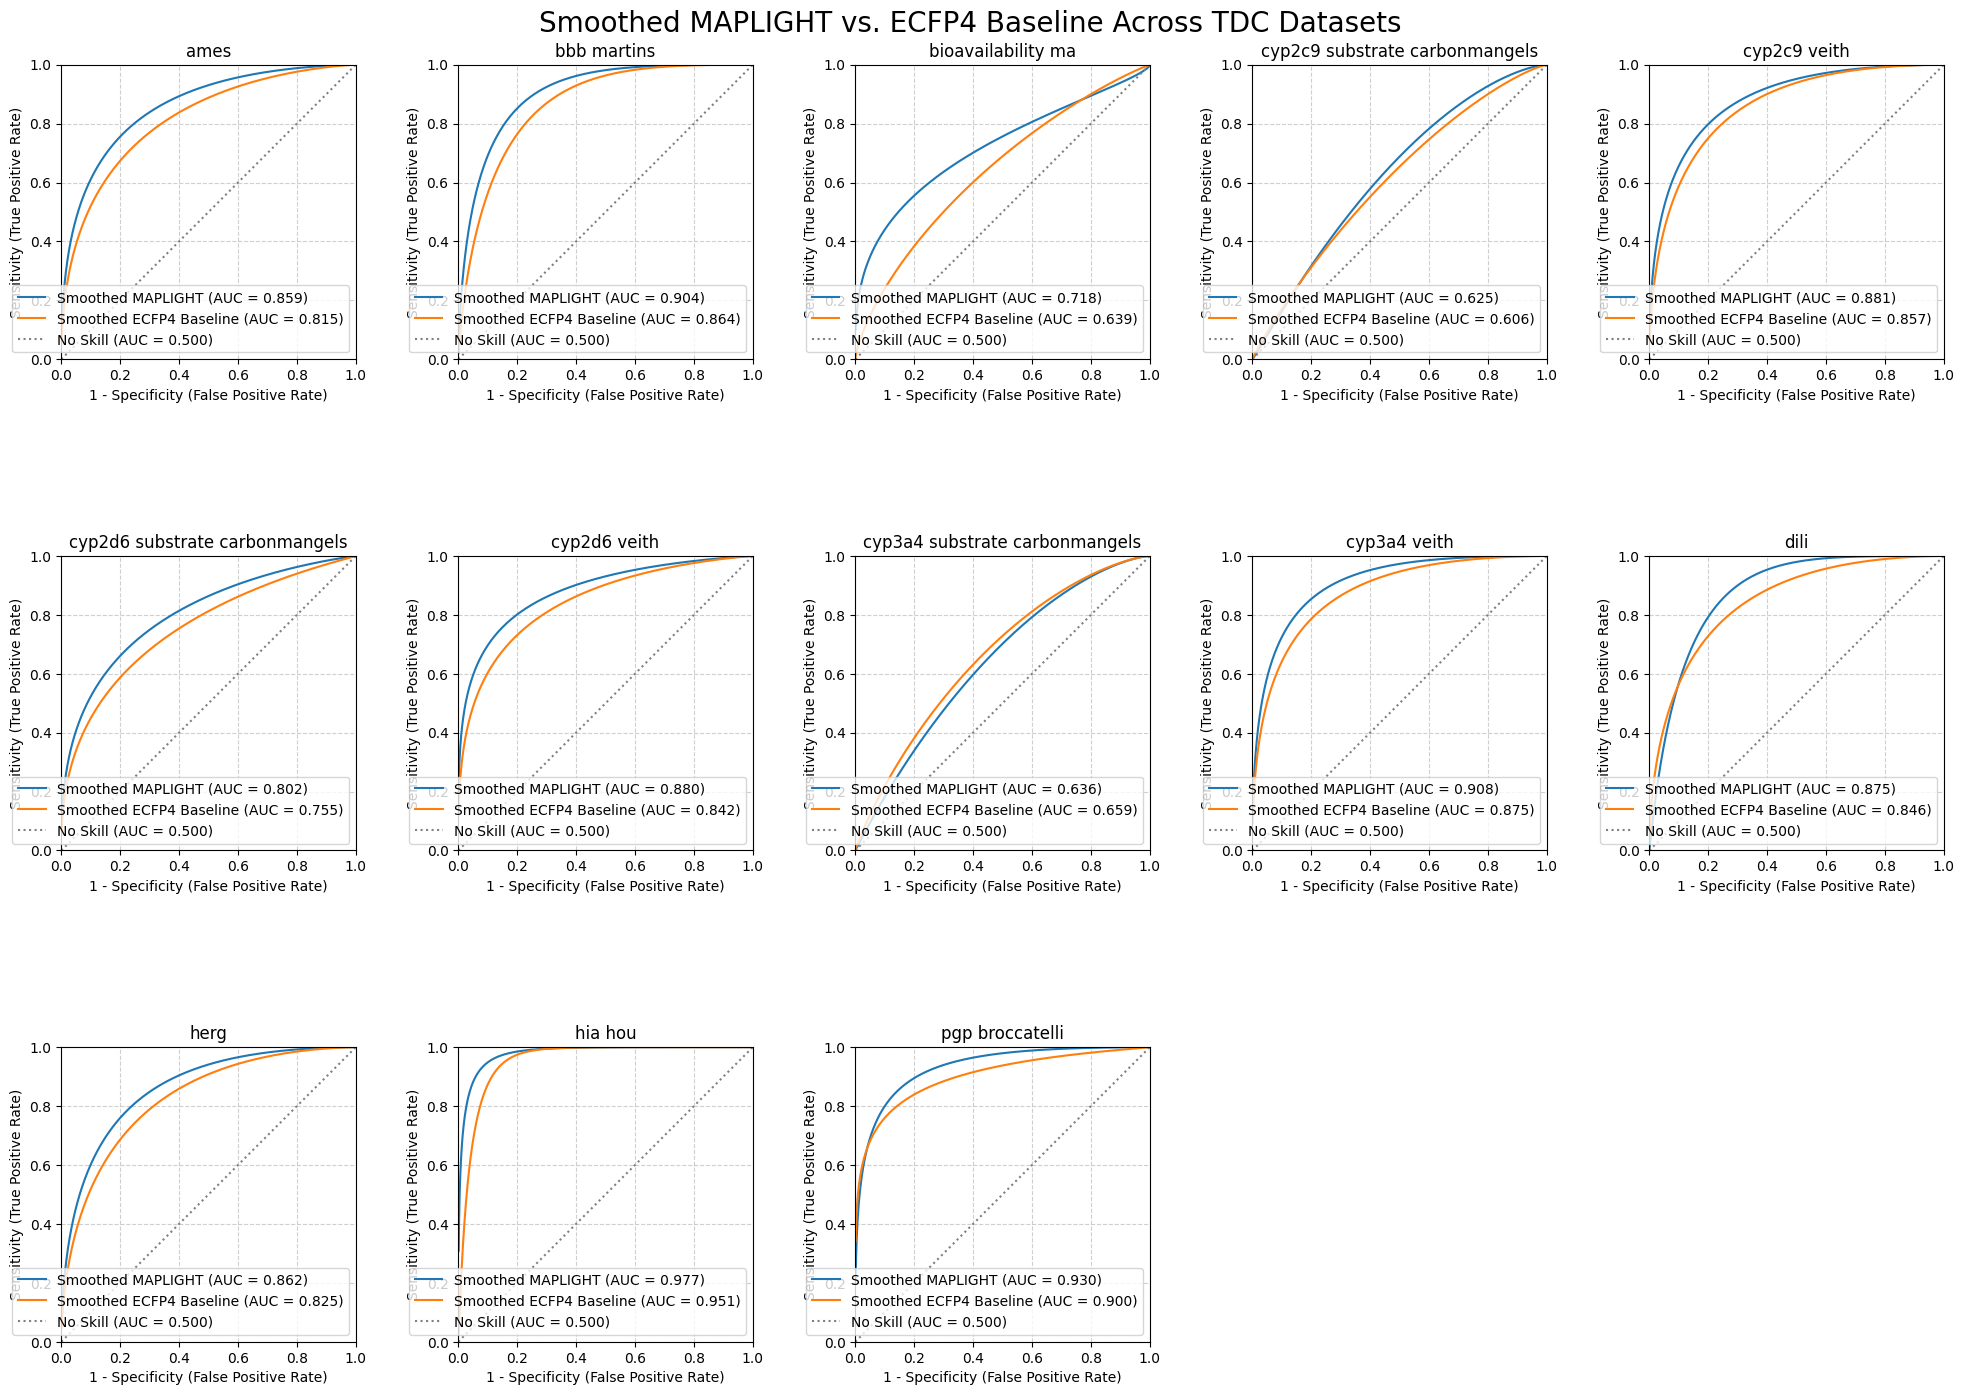

In [57]:
fig, axes = plt.subplots(3, 5, figsize=(20, 16))
axes = axes.flatten()

for i, dataset_name in tqdm(enumerate(sorted_dataset_names), total=len(sorted_dataset_names)):
    ax = axes[i] # Get the subplot

    y_true = maplight_results[f"{dataset_name}_y_true"]
    maplight_probs = maplight_results[f"{dataset_name}_y_pred_proba"]
    baseline_probs = baseline_ecfp4_results[f"{dataset_name}_y_pred_proba"]

    roc_maplight = pauc.ROC(y_true, maplight_probs, name='MAPLIGHT')
    roc_baseline = pauc.ROC(y_true, baseline_probs, name='ECFP4 Baseline')
    smoothed_roc_maplight = pauc.smooth(roc_maplight, method='binormal')
    smoothed_roc_baseline = pauc.smooth(roc_baseline, method='binormal')

    plot_roc_refactored(
        [smoothed_roc_maplight, smoothed_roc_baseline],
        title=f"{dataset_name.replace('_', ' ')}",
        ax=ax
    )

for j in range(len(sorted_dataset_names), len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('Smoothed MAPLIGHT vs. ECFP4 Baseline Across TDC Datasets', fontsize=20, y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()